# **Stress Level Detection (using Feature Data)**
**What we have tried here -**
- **Make a csv dataset extracting all the features from the Audio data**
- **Train and validate three differnt models for comparison study:**
    - **Statistical ML Model (SVM and Random Forest)**
    - **CNN Model (StressCNN)**
    - **Proposed Model (LSTM + CNN)**

**Import Library**

In [1]:
# Importing all necessary libraries
import pandas as pd
import numpy as np
import os
import librosa
import librosa.display
from IPython.display import Audio
from sklearn.preprocessing import OneHotEncoder
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
import warnings
warnings.filterwarnings('ignore')
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, accuracy_score
import seaborn as sns


**Load Dataset**

In [2]:
df= pd.read_excel("features_2.xlsx");
df.head()

,Pitch,Intensity,Frequency,Amplitude,MFCCs,Spectral Centroid,Spectral Bandwidth,Spectral Rolloff,Spectral Flux,Energy,ZCR,Tempo,Stress
0,1410.588989,0.041406,1410.588989,0.337341,"[-390.0313415527344, 55.235965728759766, -15.0...",2244.518922,2417.499675,4023.786502,(7.856366210035048e-06-8.686884029884823e-07j),0.041406,0.081048,143.050781,9
1,1168.005859,0.022364,1168.005859,0.176117,"[-451.01947021484375, 67.048828125, -0.4482572...",2182.569100,2405.502339,3817.591309,(7.408749752357835e-06-2.919421149272239e-07j),0.022364,0.085180,130.046165,9
2,1863.138916,0.029732,1863.138916,0.265015,"[-406.5633239746094, 28.609004974365234, -5.31...",2964.378675,2675.259261,5331.541280,(-3.4756992590700975e-06-8.736076779314317e-06j),0.029732,0.127679,143.050781,9
3,1489.154175,0.043054,1489.154175,0.343719,"[-386.34002685546875, 53.43965530395508, -8.66...",2636.422929,2515.913088,4431.942332,(-1.4807430943619693e-06-3.374229663677397e-06j),0.043054,0.105919,95.367188,9
4,1090.847290,0.030544,1090.847290,0.282318,"[-404.7848815917969, 54.46256637573242, 3.3552...",2330.168832,2432.395141,4295.259839,(5.316106125974329e-06+1.038062237057602e-05j),0.030544,0.076019,110.039062,9


#### **Preprocess Data**

In [3]:
# Check if any column contains NaN or null values
df.isnull().any()

Pitch                 False
Intensity             False
Frequency             False
Amplitude             False
MFCCs                 False
Spectral Centroid     False
Spectral Bandwidth    False
Spectral Rolloff      False
Spectral Flux         False
Energy                False
ZCR                   False
Tempo                 False
Stress                False
dtype: bool

In [4]:
import ast
def average_mfcc(mfcc_str):
    # Convert the string representation of list to actual list
    mfcc_list = ast.literal_eval(mfcc_str)
    # Calculate the average of the list
    return np.mean(mfcc_list)

df['MFCCs'] = df['MFCCs'].apply(average_mfcc)

In [5]:
# Convert the 'Spectral Flux' column to complex numbers if they are in string format
df['Spectral Flux'] = df['Spectral Flux'].apply(lambda x: complex(x) if isinstance(x, str) else x)

# Now calculate the magnitude (absolute value) of the complex numbers
df['Spectral Flux Magnitude'] = df['Spectral Flux'].apply(lambda x: abs(x))

In [6]:
# Drop the 'Spectral Flux' column from the DataFrame
df = df.drop(columns=['Spectral Flux'])

In [7]:
#data split
X = df.drop(columns=['Stress'])
y = df['Stress']

#### **Feature Selection**

Feature Importance (Percentage):
                     Feature       Score  Score Percentage
0                     Pitch  109.533977         46.558552
1                 Intensity  201.722409         85.744200
2                 Frequency  109.533977         46.558552
3                 Amplitude  235.260704        100.000000
4                     MFCCs   24.063334         10.228369
5         Spectral Centroid   91.840289         39.037666
6        Spectral Bandwidth   94.941430         40.355839
7          Spectral Rolloff  114.462450         48.653450
8                    Energy  201.722409         85.744200
9                       ZCR   64.025727         27.214799
10                    Tempo   70.346124         29.901349
11  Spectral Flux Magnitude   14.524479          6.173780


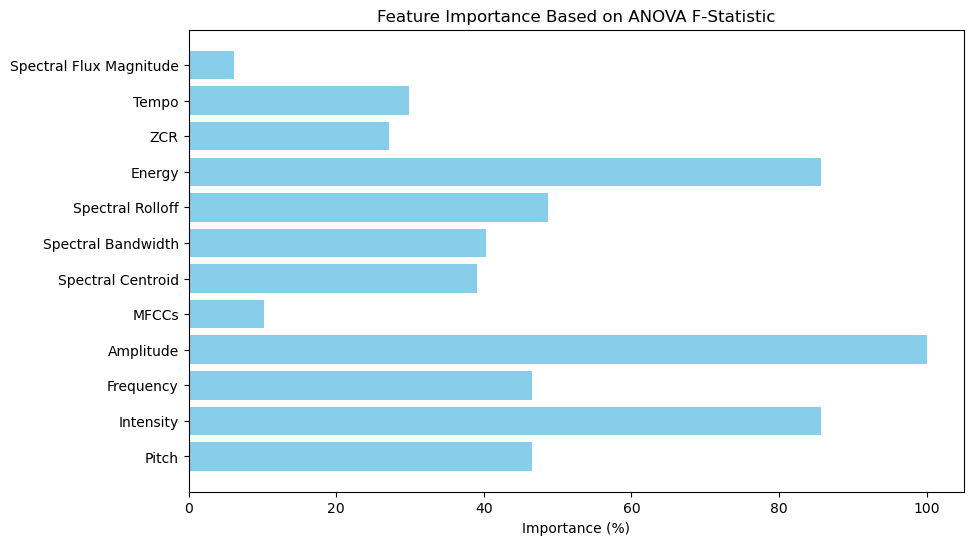

In [8]:
from sklearn.feature_selection import SelectKBest, f_classif
# Step 2: Perform Feature Selection (Select top 8 features using ANOVA F-statistic)
selector = SelectKBest(score_func=f_classif, k='all')  # 'k=all' to keep all features
X_selected = selector.fit_transform(X, y)

# Step 3: Get the feature scores and normalize them to get percentages
feature_scores = selector.scores_
max_score = max(feature_scores)
feature_scores_percentage = [score / max_score * 100 for score in feature_scores]

# Step 4: Create a DataFrame to show feature scores and percentages
selected_features_df = pd.DataFrame({
    'Feature': X.columns,
    'Score': feature_scores,
    'Score Percentage': feature_scores_percentage
})

# Display the selected features and their importance
print("Feature Importance (Percentage):\n", selected_features_df)

# Step 5: Visualization (Bar plot of feature importance)
plt.figure(figsize=(10, 6))
plt.barh(selected_features_df['Feature'], selected_features_df['Score Percentage'], color='skyblue')
plt.xlabel('Importance (%)')
plt.title('Feature Importance Based on ANOVA F-Statistic')
plt.show()

In [9]:
#finalize column
# List of selected columns
selected_columns = [
    'Intensity',
    'Amplitude',
    'Spectral Centroid',
    'Spectral Bandwidth',
    'Spectral Rolloff',
    'Energy',
    'Pitch',
    'Frequency'
]

# Filter the DataFrame to keep only the selected columns
X_selected = X[selected_columns]

# Display the resulting DataFrame
print(X_selected.head())


   Intensity  Amplitude  Spectral Centroid  Spectral Bandwidth  \
0   0.041406   0.337341        2244.518922         2417.499675   
1   0.022364   0.176117        2182.569100         2405.502339   
2   0.029732   0.265015        2964.378675         2675.259261   
3   0.043054   0.343719        2636.422929         2515.913088   
4   0.030544   0.282318        2330.168832         2432.395141   

   Spectral Rolloff    Energy        Pitch    Frequency  
0       4023.786502  0.041406  1410.588989  1410.588989  
1       3817.591309  0.022364  1168.005859  1168.005859  
2       5331.541280  0.029732  1863.138916  1863.138916  
3       4431.942332  0.043054  1489.154175  1489.154175  
4       4295.259839  0.030544  1090.847290  1090.847290  


#### **Check SVM and Random Forest Model**

**Train-Test Split**

In [10]:
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)
# Further split X_train into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

**Normilazition:** `[converting data values in a certain range]`

In [11]:
# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

****Initialize Models and Train****

In [12]:
# Initialize models
svc_model = SVC(kernel='rbf', probability=True, random_state=42)
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

In [13]:
# Train and evaluate models
history = {"svc": {"train_acc": [], "val_acc": []}, "rf": {"train_acc": [], "val_acc": []}}

# SVC Model
svc_model.fit(X_train, y_train)
svc_train_acc = svc_model.score(X_train, y_train)
svc_val_acc = svc_model.score(X_val, y_val)
history["svc"]["train_acc"].append(svc_train_acc)
history["svc"]["val_acc"].append(svc_val_acc)
svc_predictions = svc_model.predict(X_test)
svc_probs = svc_model.predict_proba(X_test)[:, 1]

# Random Forest Model
rf_model.fit(X_train, y_train)
rf_train_acc = rf_model.score(X_train, y_train)
rf_val_acc = rf_model.score(X_val, y_val)
history["rf"]["train_acc"].append(rf_train_acc)
history["rf"]["val_acc"].append(rf_val_acc)
rf_predictions = rf_model.predict(X_test)
rf_probs = rf_model.predict_proba(X_test)[:, 1]

`Classification Reports`

In [14]:
# Classification Reports
print("SVC Classification Report:\n", classification_report(y_test, svc_predictions))
print("Random Forest Classification Report:\n", classification_report(y_test, rf_predictions))

SVC Classification Report:
               precision    recall  f1-score   support

           1       0.59      0.75      0.66        73
           2       0.58      0.73      0.65        77
           4       0.68      0.56      0.61        82
           5       0.61      0.62      0.61        87
           6       0.74      0.67      0.70        78
           8       0.70      0.61      0.65        89
           9       0.66      0.59      0.62        74

    accuracy                           0.64       560
   macro avg       0.65      0.65      0.64       560
weighted avg       0.65      0.64      0.64       560

Random Forest Classification Report:
               precision    recall  f1-score   support

           1       0.80      0.73      0.76        73
           2       0.60      0.77      0.67        77
           4       0.75      0.80      0.78        82
           5       0.62      0.62      0.62        87
           6       0.79      0.76      0.77        78
           8

`Confusion Matrixs`

In [15]:
# Confusion Matrices
svc_cm = confusion_matrix(y_test, svc_predictions)
rf_cm = confusion_matrix(y_test, rf_predictions)

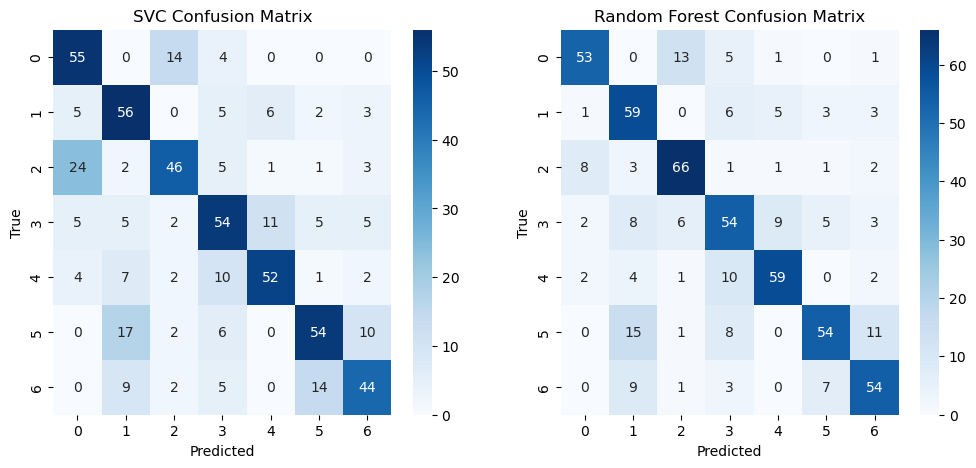

In [16]:
# Plot Confusion Matrices
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.heatmap(svc_cm, annot=True, fmt='d', cmap="Blues")
plt.title("SVC Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")

plt.subplot(1, 2, 2)
sns.heatmap(rf_cm, annot=True, fmt='d', cmap="Blues")
plt.title("Random Forest Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

#### **CNN Model**

**Transform Data** `[Getting ready data for cnn model]`

In [17]:
X_scaled = scaler.fit_transform(X)

print(X_scaled)

[[-0.47551382  0.58762502 -0.47551382 ... -1.11005622  0.76803954
   0.37982777]
 [-1.15943724 -0.44187184 -1.15943724 ... -1.03141218  0.2154015
   0.31091928]
 [ 0.80037662 -0.043507    0.80037662 ... -0.22252363  0.76803954
   0.59057947]
 ...
 [-2.70469165  0.662916   -2.70469165 ...  0.41999564 -1.25829996
  -0.41738433]
 [-1.53234058 -0.10110286 -1.53234058 ... -0.52452091 -1.38903154
  -0.58921565]
 [-0.85374127 -0.05422649 -0.85374127 ...  0.25295812  1.84080751
  -0.11823656]]


**Reshape Data** `[convery 2d data into 1d to make it suitable for out model]`

In [18]:
# Reshape the data for the CNN input (e.g., [batch_size, channels, height, width])
# Here, we assume 1 channel, and the features can be treated as a 2D input (for example, each row is a feature vector).

X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1], 1)  # [samples, channels, feature_size, 1]
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1], 1)  # [samples, channels, feature_size, 1]

In [19]:
X_train_final, X_val, y_train_final, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

**Convert Numpy Data to Tenson**

In [20]:
# Convert NumPy arrays and pandas Series to PyTorch tensors
X_train_tensor = torch.tensor(X_train_final, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

y_train_tensor = torch.tensor(y_train_final.to_numpy(), dtype=torch.long)  # Convert Series to NumPy array
y_val_tensor = torch.tensor(y_val.to_numpy(), dtype=torch.long)  # Convert Series to NumPy array
y_test_tensor = torch.tensor(y_test.to_numpy(), dtype=torch.long)  # Convert Series to NumPy array

In [21]:
print(f'x_train_tensor={X_train_tensor.shape}, X_val_tensor={X_val_tensor.shape}, X_test_tensor={X_test_tensor.shape}, y_train_tensor={y_train_tensor.shape}, y_val_tensor={y_val_tensor.shape},y_test_tensor={y_test_tensor.shape} ')

x_train_tensor=torch.Size([1433, 1, 8, 1]), X_val_tensor=torch.Size([359, 1, 8, 1]), X_test_tensor=torch.Size([560, 1, 8, 1]), y_train_tensor=torch.Size([1433]), y_val_tensor=torch.Size([359]),y_test_tensor=torch.Size([560]) 


**Further reshape to 1D**

In [22]:
# Reshaping input tensor to match Conv1d's expected input shape [batch_size, channels, sequence_length]
X_train_tensor = X_train_tensor.view(X_train_tensor.size(0), 1, -1)  # [1792, 1, 8]
X_val_tensor = X_val_tensor.view(X_val_tensor.size(0), 1, -1)        # [448, 1, 8]
X_test_tensor = X_test_tensor.view(X_test_tensor.size(0), 1, -1)      # [560, 1, 8]

y_train_tensor = y_train_tensor - 1
y_val_tensor = y_val_tensor - 1
y_test_tensor = y_test_tensor - 1

print(f'x_train_tensor={X_train_tensor.shape}, X_val_tensor={X_val_tensor.shape}, X_test_tensor={X_test_tensor.shape}, y_train_tensor={y_train_tensor.shape}, y_val_tensor={y_val_tensor.shape}, y_test_tensor={y_test_tensor.shape}')


x_train_tensor=torch.Size([1433, 1, 8]), X_val_tensor=torch.Size([359, 1, 8]), X_test_tensor=torch.Size([560, 1, 8]), y_train_tensor=torch.Size([1433]), y_val_tensor=torch.Size([359]), y_test_tensor=torch.Size([560])


In [23]:
print(f"Max label in y_train_tensor: {y_train_tensor.max()}")
print(f"Min label in y_train_tensor: {y_train_tensor.min()}")


Max label in y_train_tensor: 8
Min label in y_train_tensor: 0


**CNN Model Difinition**

In [24]:
# Define the model
class StressCNN(nn.Module):
    def __init__(self, num_classes=9):  # Changed from 7 to 9
        super(StressCNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(64 * 2, 128)  # Adjusted size after calculating conv output
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, num_classes)  # This should match the number of classes

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

**Training ...**

In [25]:
# Define model, loss, and optimizer
model = StressCNN(num_classes=9)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Track history
history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}

# Early stopping parameters
early_stop_patience = 20  # Number of epochs to wait for improvement in validation loss
best_val_loss = float('inf')
patience_counter = 0

# Training loop with validation and early stopping
for epoch in range(500):  # Train for up to 200 epochs or until early stopping
    model.train()  # Set the model to training mode
    optimizer.zero_grad()
    
    # Forward pass on training data
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    
    # Calculate training accuracy
    _, predicted = torch.max(outputs, 1)
    correct = (predicted == y_train_tensor).sum().item()
    train_accuracy = correct / y_train_tensor.size(0) * 100

    # Validation step
    model.eval()  # Set the model to evaluation mode for validation
    with torch.no_grad():
        val_outputs = model(X_val_tensor)
        val_loss = criterion(val_outputs, y_val_tensor)
        _, val_predicted = torch.max(val_outputs, 1)
        val_correct = (val_predicted == y_val_tensor).sum().item()
        val_accuracy = val_correct / y_val_tensor.size(0) * 100

    # Store history
    history["train_loss"].append(loss.item())
    history["val_loss"].append(val_loss.item())
    history["train_acc"].append(train_accuracy)
    history["val_acc"].append(val_accuracy)

    # Print progress
    print(f"Epoch [{epoch+1}/200], Train Loss: {loss.item():.4f}, Train Accuracy: {train_accuracy:.2f}%")
    print(f"Validation Loss: {val_loss.item():.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    # Early stopping check based on validation loss
    if val_loss.item() < best_val_loss:
        best_val_loss = val_loss.item()
        patience_counter = 0  # Reset counter if improvement
    else:
        patience_counter += 1

    # Trigger early stopping if validation loss doesn't improve
    if patience_counter >= early_stop_patience:
        print(f"Early stopping at epoch {epoch+1}. Best Validation Loss: {best_val_loss:.4f}")
        break

Epoch [1/200], Train Loss: 2.2034, Train Accuracy: 14.38%
Validation Loss: 2.1758, Validation Accuracy: 15.32%
Epoch [2/200], Train Loss: 2.1797, Train Accuracy: 15.14%
Validation Loss: 2.1521, Validation Accuracy: 15.88%
Epoch [3/200], Train Loss: 2.1573, Train Accuracy: 16.89%
Validation Loss: 2.1303, Validation Accuracy: 17.55%
Epoch [4/200], Train Loss: 2.1352, Train Accuracy: 18.77%
Validation Loss: 2.1088, Validation Accuracy: 18.11%
Epoch [5/200], Train Loss: 2.1141, Train Accuracy: 19.12%
Validation Loss: 2.0871, Validation Accuracy: 20.61%
Epoch [6/200], Train Loss: 2.0879, Train Accuracy: 19.96%
Validation Loss: 2.0646, Validation Accuracy: 21.17%
Epoch [7/200], Train Loss: 2.0638, Train Accuracy: 21.00%
Validation Loss: 2.0411, Validation Accuracy: 21.45%
Epoch [8/200], Train Loss: 2.0404, Train Accuracy: 23.10%
Validation Loss: 2.0166, Validation Accuracy: 21.73%
Epoch [9/200], Train Loss: 2.0201, Train Accuracy: 22.12%
Validation Loss: 1.9909, Validation Accuracy: 21.73%
E

**Visualize the Training Results**

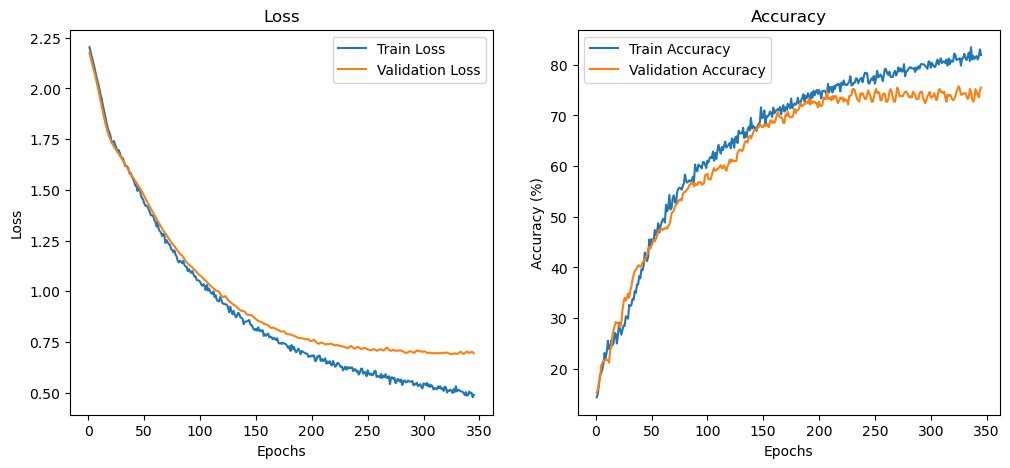


Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.86      0.83        57
           1       0.67      0.69      0.68        52
           3       0.80      0.73      0.76        55
           4       0.72      0.66      0.69        50
           5       0.78      0.81      0.80        43
           7       0.72      0.84      0.78        50
           8       0.80      0.69      0.74        52

    accuracy                           0.75       359
   macro avg       0.76      0.76      0.75       359
weighted avg       0.76      0.75      0.75       359



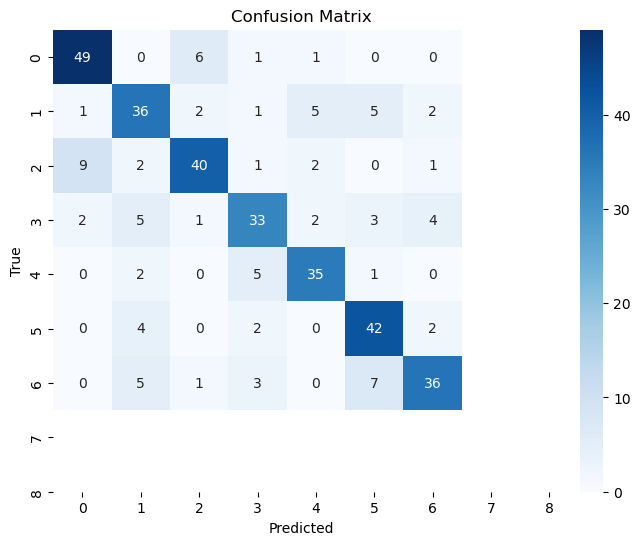

ROC curve and AUC are only applicable for binary classification.


In [26]:

# Plot loss and accuracy curves
def plot_history(history):
    epochs = range(1, len(history["train_loss"]) + 1)
    plt.figure(figsize=(12, 5))

    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history["train_loss"], label="Train Loss")
    plt.plot(epochs, history["val_loss"], label="Validation Loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history["train_acc"], label="Train Accuracy")
    plt.plot(epochs, history["val_acc"], label="Validation Accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy (%)")
    plt.legend()

    plt.show()

plot_history(history)

# Classification report
val_pred = val_predicted.cpu().numpy()
val_true = y_val_tensor.cpu().numpy()
print("\nClassification Report:\n", classification_report(val_true, val_pred))

# Confusion matrix
cm = confusion_matrix(val_true, val_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=range(9), yticklabels=range(9))
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# # ROC and AUC
# if len(set(val_true)) == 2:  # Binary classification
#     val_probs = torch.softmax(val_outputs, dim=1)[:, 1].cpu().numpy()
#     auc = roc_auc_score(val_true, val_probs)
#     fpr, tpr, _ = roc_curve(val_true, val_probs)

#     plt.figure(figsize=(8, 6))
#     plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
#     plt.plot([0, 1], [0, 1], "--", color="gray")
#     plt.title("ROC Curve")
#     plt.xlabel("False Positive Rate")
#     plt.ylabel("True Positive Rate")
#     plt.legend()
#     plt.show()
# else:
#     print("ROC curve and AUC are only applicable for binary classification.")


#### **Proposed (LSTM + CNN) Model**

**Model Definition**

In [27]:
# Define the model
class LSTM_CNN_Model(nn.Module):
    def __init__(self, input_dim, hidden_dim, lstm_layers, cnn_channels, num_classes):
        super(LSTM_CNN_Model, self).__init__()

        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=lstm_layers, batch_first=True, bidirectional=True)
        self.conv1 = nn.Conv1d(in_channels=hidden_dim * 2, out_channels=cnn_channels, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.global_avg_pool = nn.AdaptiveAvgPool1d(1)
        self.fc1 = nn.Linear(cnn_channels, 128)
        self.fc2 = nn.Linear(128, num_classes)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x, (hn, cn) = self.lstm(x)
        x = x.permute(0, 2, 1)
        x = self.relu(self.conv1(x))
        x = self.global_avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

**Training ...**

In [28]:
# Initialize model, criterion, and optimizer
model = LSTM_CNN_Model(input_dim=8, hidden_dim=64, lstm_layers=2, cnn_channels=32, num_classes=9)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Track history
history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}

# Early stopping parameters
early_stop_patience = 20
best_val_loss = float('inf')
patience_counter = 0

# Training loop
for epoch in range(500):
    model.train()
    optimizer.zero_grad()

    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

    _, predicted = torch.max(outputs, 1)
    correct = (predicted == y_train_tensor).sum().item()
    train_accuracy = correct / y_train_tensor.size(0) * 100

    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val_tensor)
        val_loss = criterion(val_outputs, y_val_tensor)
        _, val_predicted = torch.max(val_outputs, 1)
        val_correct = (val_predicted == y_val_tensor).sum().item()
        val_accuracy = val_correct / y_val_tensor.size(0) * 100

    # Store history
    history["train_loss"].append(loss.item())
    history["val_loss"].append(val_loss.item())
    history["train_acc"].append(train_accuracy)
    history["val_acc"].append(val_accuracy)

    # Verbose output
    print(f"Epoch [{epoch+1}/200], Train Loss: {loss.item():.4f}, Train Accuracy: {train_accuracy:.2f}%")
    print(f"Validation Loss: {val_loss.item():.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    if val_loss.item() < best_val_loss:
        best_val_loss = val_loss.item()
        patience_counter = 0
    else:
        patience_counter += 1

    if patience_counter >= early_stop_patience:
        print(f"Early stopping at epoch {epoch+1}. Best Validation Loss: {best_val_loss:.4f}")
        break



Epoch [1/200], Train Loss: 2.2203, Train Accuracy: 1.67%
Validation Loss: 2.2114, Validation Accuracy: 0.00%
Epoch [2/200], Train Loss: 2.2152, Train Accuracy: 3.42%
Validation Loss: 2.2071, Validation Accuracy: 0.00%
Epoch [3/200], Train Loss: 2.2097, Train Accuracy: 4.95%
Validation Loss: 2.2029, Validation Accuracy: 0.00%
Epoch [4/200], Train Loss: 2.2054, Train Accuracy: 6.35%
Validation Loss: 2.1987, Validation Accuracy: 11.98%
Epoch [5/200], Train Loss: 2.2018, Train Accuracy: 9.00%
Validation Loss: 2.1945, Validation Accuracy: 15.88%
Epoch [6/200], Train Loss: 2.1984, Train Accuracy: 9.77%
Validation Loss: 2.1903, Validation Accuracy: 15.88%
Epoch [7/200], Train Loss: 2.1943, Train Accuracy: 12.21%
Validation Loss: 2.1860, Validation Accuracy: 15.88%
Epoch [8/200], Train Loss: 2.1904, Train Accuracy: 12.07%
Validation Loss: 2.1816, Validation Accuracy: 15.88%
Epoch [9/200], Train Loss: 2.1859, Train Accuracy: 13.40%
Validation Loss: 2.1772, Validation Accuracy: 15.88%
Epoch [10/

**Visualize the Training Results**

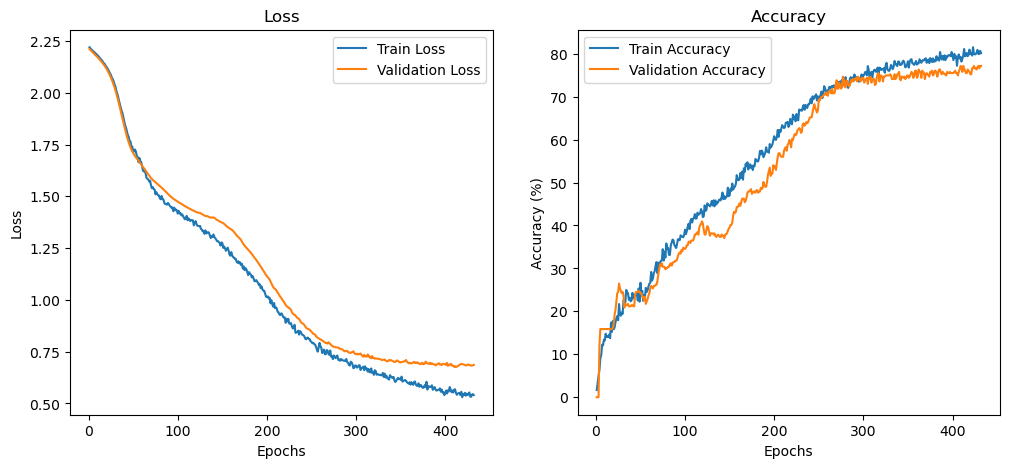


Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.84      0.83        57
           1       0.69      0.71      0.70        52
           3       0.83      0.80      0.81        55
           4       0.70      0.60      0.65        50
           5       0.79      0.88      0.84        43
           7       0.74      0.84      0.79        50
           8       0.83      0.73      0.78        52

    accuracy                           0.77       359
   macro avg       0.77      0.77      0.77       359
weighted avg       0.77      0.77      0.77       359



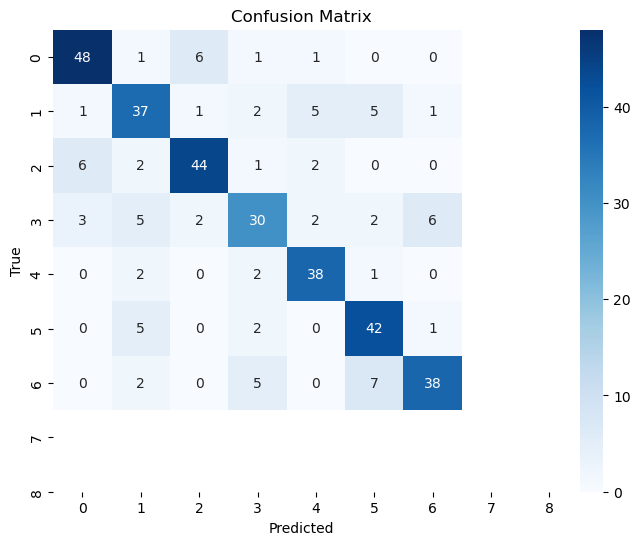

ROC curve and AUC are only applicable for binary classification.


In [29]:

# Plot loss and accuracy curves
def plot_history(history):
    epochs = range(1, len(history["train_loss"]) + 1)
    plt.figure(figsize=(12, 5))

    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history["train_loss"], label="Train Loss")
    plt.plot(epochs, history["val_loss"], label="Validation Loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history["train_acc"], label="Train Accuracy")
    plt.plot(epochs, history["val_acc"], label="Validation Accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy (%)")
    plt.legend()

    plt.show()

plot_history(history)

# Classification report
val_pred = val_predicted.cpu().numpy()
val_true = y_val_tensor.cpu().numpy()
print("\nClassification Report:\n", classification_report(val_true, val_pred))

# Confusion matrix
cm = confusion_matrix(val_true, val_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=range(9), yticklabels=range(9))
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# ROC and AUC
if len(set(val_true)) == 2:  # Binary classification
    val_probs = torch.softmax(val_outputs, dim=1)[:, 1].cpu().numpy()
    auc = roc_auc_score(val_true, val_probs)
    fpr, tpr, _ = roc_curve(val_true, val_probs)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
    plt.plot([0, 1], [0, 1], "--", color="gray")
    plt.title("ROC Curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.show()
else:
    print("ROC curve and AUC are only applicable for binary classification.")